In [2]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pylab as plt
from matplotlib import pyplot
import pickle

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [15, 10]
pyplot.rcParams['figure.figsize'] = [15, 10]

In [3]:
x = pd.read_pickle('Tables/feature_df.pkl')
y = pd.read_csv('Tables/target_df.csv').drop(columns=['Unnamed: 0'])

### Model Setup
- train test split
- define xgboost train
- define xgboost test
- define hyperparameters

In [4]:
y['state'] = y['state'].replace({'successful': 1, 'failed': 0})

In [5]:
seed = 10
test_size = .3
x_train, x_test, y_train, y_test = train_test_split(x.drop(columns=['id']), y, test_size=test_size, random_state=seed)
y_test['state'] = y_test['state'].replace({'successful': 1, 'failed': 0})

In [6]:
x_train.to_pickle('Tables/x_train.pkl')
x_test.to_pickle('Tables/x_test.pkl')
y_train.to_pickle('Tables/y_train.pkl')
y_test.to_pickle('Tables/y_test.pkl')

In [7]:
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': .05,
            'n_estimators':1000,
            'eval_metric': 'map'
        }        

model = XGBClassifier(**params, use_label_encoder=False)
model.fit(x_train, y_train)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='map', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

In [8]:
# get the current Workspace

from azureml.core import Workspace
ws = Workspace.get(name='kickstarter-v2',
               subscription_id='56b451c2-60d1-45a0-aae3-8622f9b01361',
               resource_group='DS-Practice',
               )

In [9]:
# Register the model for use as an endpoint to be called by other script

from azureml.core.model import Model

model = Model.register(model_path="Models/finalized_model.pkl",
                       model_name="kickstarter-classifier",
                       tags={'area': "kickstarter", 'type': "classification"},
                       description="Classification model to predict successful kickstarter fundraisers",
                       workspace=ws)

Registering model kickstarter-classifier


In [11]:
# Keeping local pickle integration

filename = 'Models/finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [30]:
# Load model from pickle file for local integration
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict_proba(x_test)

array([[0.01685733, 0.9831427 ],
       [0.14400786, 0.85599214],
       [0.00944209, 0.9905579 ],
       ...,
       [0.42698294, 0.57301706],
       [0.09766889, 0.9023311 ],
       [0.07120508, 0.9287949 ]], dtype=float32)

In [31]:
# probability that the output belongs to class 1 (successful)
y_pred_proba = model.predict_proba(x_test)[:,1]

In [32]:
# 5 splits allows for enough data at each split while also being a sufficient number of folds for confidence in the resulting score
kfold = KFold(n_splits=5)
results = cross_val_score(model, x, y['state'], cv=kfold, scoring='precision')

`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


In [33]:
#mean precision score from cross validation
results.mean()

0.8432572486538493

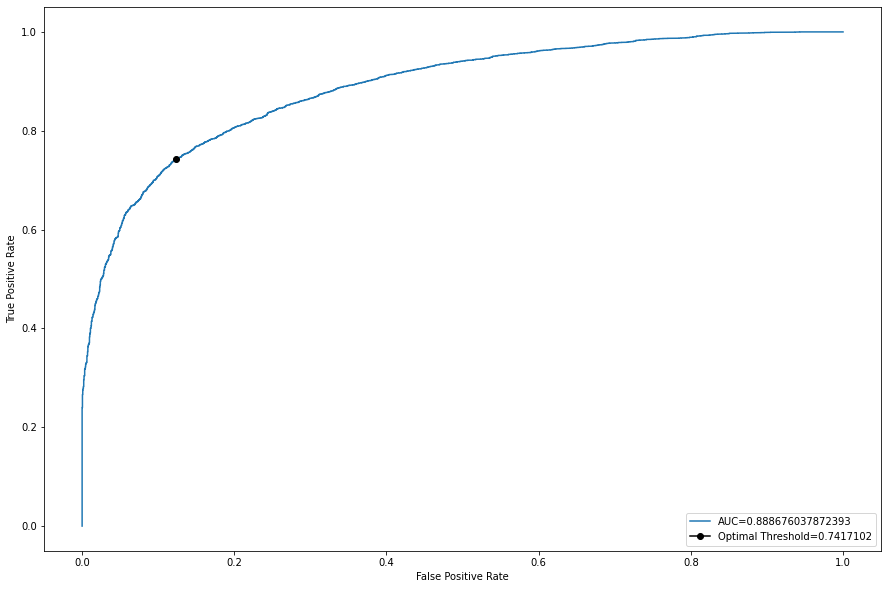

In [34]:
#Roc Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.auc(fpr, tpr)

# Youden's J statistic to find the optimal threshold value
j = tpr - fpr
ix = np.argmax(j)
best_threshold = thresholds[ix]

#plot the ROC with the optimal threshold labeled
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot(fpr[ix], tpr[ix], marker = 'o', color = 'black', label='Optimal Threshold='+str(best_threshold))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

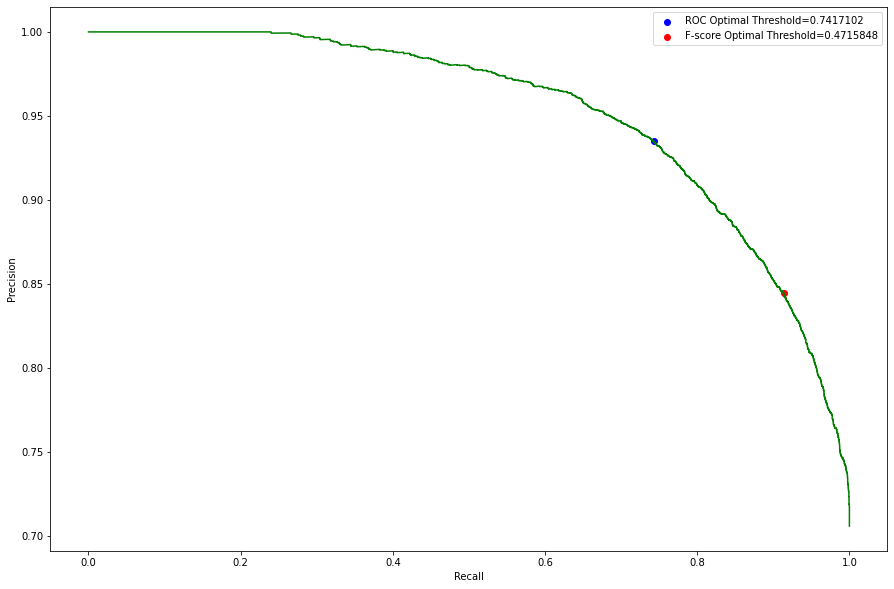

In [35]:
# Precision recall curve to test thresholds
# Compare AUC optimized threshold with F1 optimixed recall
# Since the goal of the model is precision, the one with the higher precision score will be selected
precision,recall,thresholds_f = metrics.precision_recall_curve(y_test,y_pred_proba)
fscore = (2 * precision * recall) / (precision + recall)
ix_f = np.argmax(fscore)
index, = np.where(thresholds_f == best_threshold)

# Threshold from the ROC curve
best_threshold_roc = thresholds_f[index]
# Threshold to maximize f-score
best_threshold_f = thresholds_f[ix_f]

plt.plot(recall,precision, color='green')
plt.scatter(recall[index[0]], precision[index[0]], marker='o', color = 'blue', label='ROC Optimal Threshold='+str(best_threshold_roc[0]))
plt.scatter(recall[ix_f], precision[ix_f], marker='o', color = 'red', label='F-score Optimal Threshold='+str(best_threshold_f))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Since ROC Threshold is optimized for the ROC curve and has a high precision score, it will be used as the prediction threshold. In this classification problem, it is better to target a high precision score since we want to be sure that a project will actually be successul if it is predicted as successful

In [37]:
y_train_untuned_pred = model.predict(x_train)
train_precision_untuned = metrics.precision_score(y_train,y_train_untuned_pred)

In [38]:
y_train_tuned_pred = (model.predict_proba(x_train)[:,1] >= best_threshold_roc).astype(int)
train_precision_tuned = metrics.precision_score(y_train,y_train_tuned_pred)

In [39]:
print("TRAINING SET: untuned precision = "+str(train_precision_untuned)+", tuned_precision = "+str(train_precision_tuned)+". That is a gain of "+str(train_precision_tuned - train_precision_untuned)+"!")

TRAINING SET: untuned precision = 0.8596343769699517, tuned_precision = 0.9369035485963124. That is a gain of 0.07726917162636071!


In [40]:
y_test_untuned_pred = model.predict(x_test)
test_precision_untuned = metrics.precision_score(y_test,y_test_untuned_pred)

In [41]:
y_test_tuned_pred = (model.predict_proba(x_test)[:,1] >= best_threshold_roc).astype(int)
test_precision_tuned = metrics.precision_score(y_test,y_test_tuned_pred)

In [42]:
print("TESTING SET: untuned precision = "+str(test_precision_untuned)+", tuned_precision = "+str(test_precision_tuned)+". That is a gain of "+str(test_precision_tuned-test_precision_untuned)+"!")

TESTING SET: untuned precision = 0.8520543406229291, tuned_precision = 0.9350363356088968. That is a gain of 0.0829819949859677!


### Model Explainability

In [ ]:
import shap

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


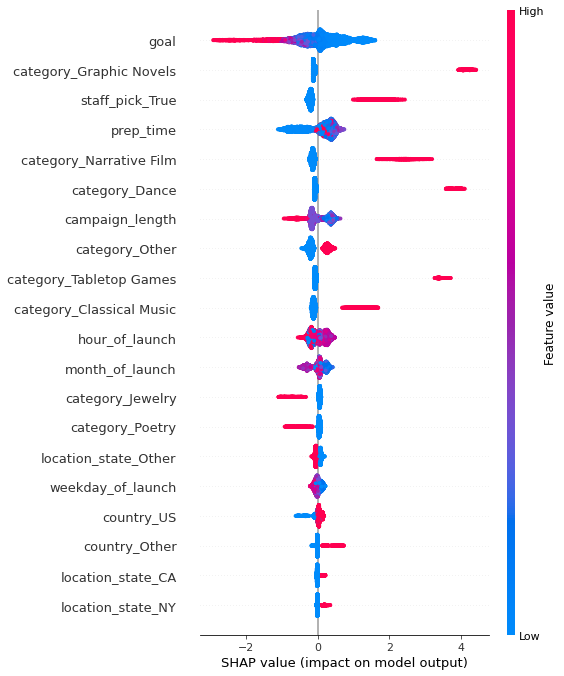

In [43]:
# Explain the entire dataset

explainer = shap.TreeExplainer(model)
shap_values = explainer(x_test)
shap.summary_plot(shap_values, x_test)

In [66]:
# Enforce underlying data dtypes to ensure graphing functions correctly (ran into error appending string and boolean datatypes in underlying data)

shap_values.data = shap_values[0:].data.astype('str')

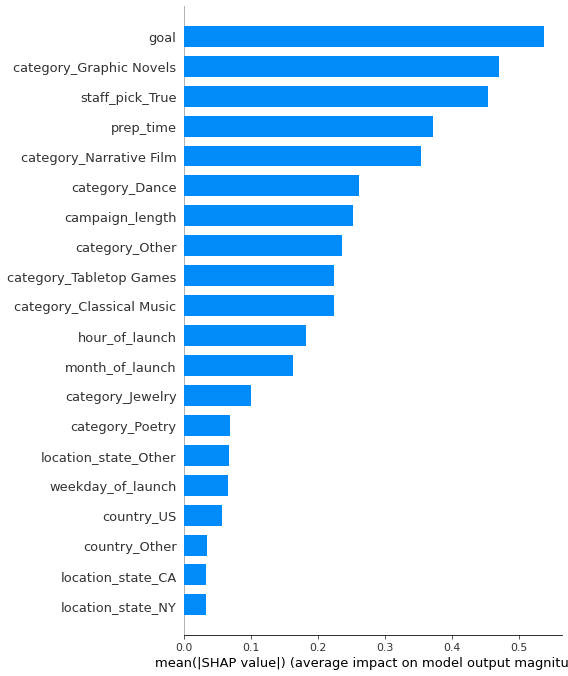

In [67]:
# Top 20 most influential features for affecting model output

shap.summary_plot(shap_values, x_test, plot_type='bar')

In [45]:
x_test.head(1)
# add order column to link to shap values output

,goal,campaign_length,prep_time,month_of_launch,weekday_of_launch,hour_of_launch,location_state_CA,location_state_England,location_state_FL,location_state_IL,location_state_MA,location_state_NY,location_state_Other,location_state_PA,location_state_TX,location_state_WA,country_AU,country_CA,country_DE,country_ES,country_FR,country_GB,country_IT,country_MX,country_Other,country_US,category_Classical Music,category_Dance,category_Graphic Novels,category_Jewelry,category_Narrative Film,category_Other,category_Performances,category_Poetry,category_Tabletop Games,category_Wearables,staff_pick_True,is_starrable_False
5142,1000.0,30,2,10,0,15,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True


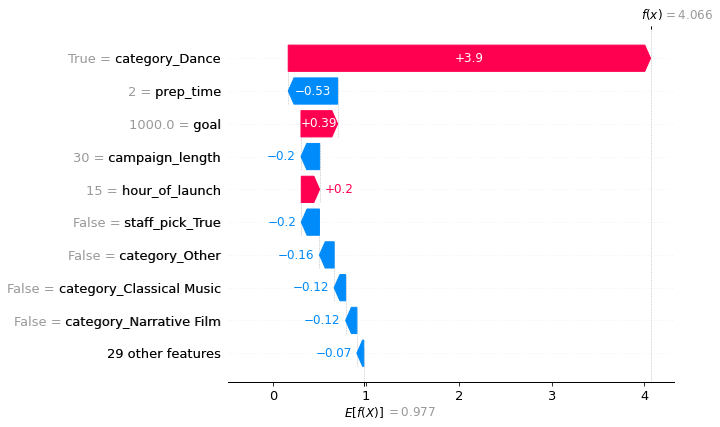

In [69]:
# Explain an individual row

shap.plots.waterfall(shap_values[0])

In [70]:
#user input project id value. can also use other columns for user to input
row_id_value = 2090953465

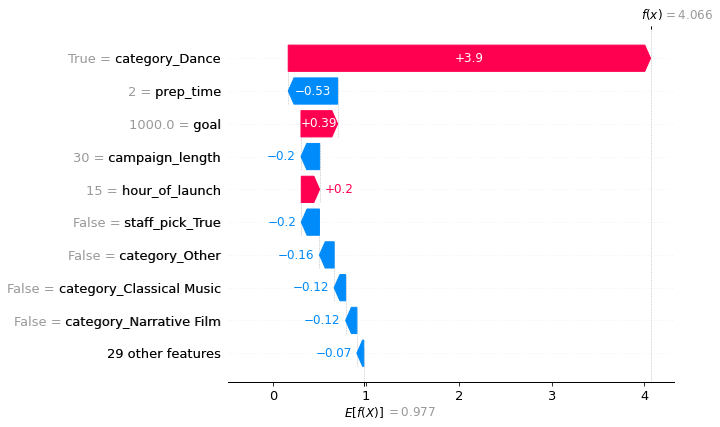

In [71]:
# copy of x_test and x to get ids. Add error handling if project id is not in test data
shap_test = x_test.copy()
x_id = x.copy()
x_id = x_id[['id']]
shap_test['order'] = np.arange(len(shap_test))
shap_test_id = shap_test.merge(x_id, left_index=True, right_index=True)
shap_reference = shap_test_id[shap_test_id['id']==row_id_value]['order'].values[0]
shap.plots.waterfall(shap_values[:,:][shap_reference])

In [72]:
# Set the query for class to query
state_query = 'state==1'

In [73]:
# Top 5 successful projects that were furthest off in prediction

test = pd.concat([x_test, y_test], axis=1)
test['probability'] = y_pred_proba
test['predictions'] = y_test_tuned_pred.astype(bool)
test['order'] = np.arange(len(test))
test.query(state_query).nsmallest(5, 'probability')

,goal,campaign_length,prep_time,month_of_launch,weekday_of_launch,hour_of_launch,location_state_CA,location_state_England,location_state_FL,location_state_IL,location_state_MA,location_state_NY,location_state_Other,location_state_PA,location_state_TX,location_state_WA,country_AU,country_CA,country_DE,country_ES,country_FR,country_GB,country_IT,country_MX,country_Other,country_US,category_Classical Music,category_Dance,category_Graphic Novels,category_Jewelry,category_Narrative Film,category_Other,category_Performances,category_Poetry,category_Tabletop Games,category_Wearables,staff_pick_True,is_starrable_False,state,probability,predictions,order
23222,20000.0,45,0,8,4,21,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,1,0.071656,False,6409
21629,55000.0,30,8,1,2,19,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,1,0.077197,False,3032
20418,10000.0,60,0,7,5,21,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,1,0.078000,False,4488
4831,23000.0,30,2,6,4,20,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,1,0.096962,False,4726
24678,100000.0,60,1,7,2,17,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,1,0.103082,False,1392


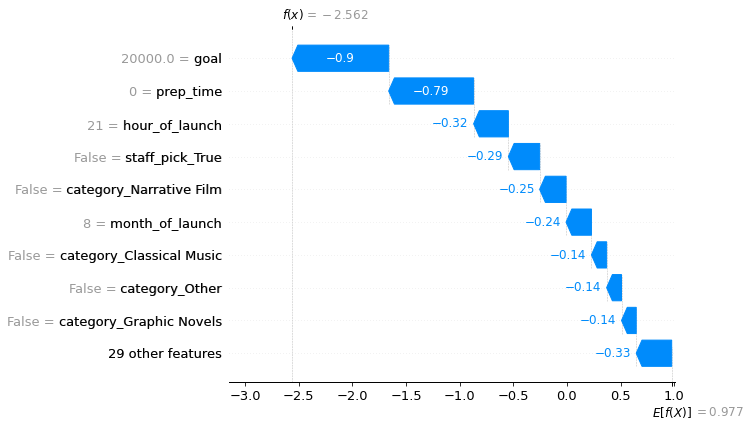

In [74]:
# Explain the furthest off prediction (predicts not successful when it was successful)
# At the top is the base value, then each feature affects the base value to get to the final value(number between 1 and 0)

project = test.query(state_query)\
           .nsmallest(1, 'probability')
project_order = project['order'].values[0]
shap.plots.waterfall(shap_values[:,:][project_order])

In [75]:
full_df = pd.concat([x_test, y_test], axis=1)
full_df['probability'] = y_pred_proba
full_df['predictions'] = y_test_tuned_pred.astype(bool)
full_df['order'] = np.arange(len(test))

In [76]:
def concat_shap(feature):
    return(feature+'_shap')

In [77]:
# Creating a dataframe to collect each projects shap values

features = x_test.columns.values
shap_feature_names = np.apply_along_axis(concat_shap,0,features)
sorted_shap_feature_names = np.sort(shap_feature_names)

shap_df = pd.DataFrame(columns=sorted_shap_feature_names)

In [78]:
# gets the shap values for each project, transposes the shap values, and then appends them to the shap df

for o in full_df['order']:
    index = float(full_df[full_df['order']==o].index[0])
    vals = shap_values[:,:][o].values
    features = x_test.columns.values
    features_shap = np.apply_along_axis(concat_shap, 0, features)
    shap_row = pd.DataFrame(list(zip(features_shap, vals)), columns=['col_name','shap_value'])
    shap_row_sorted = shap_row.sort_values(by=['col_name'])
    shap_row_transposed = shap_row_sorted.set_index('col_name').T
    shap_df = pd.concat([shap_df, shap_row_transposed], ignore_index= True)

KeyboardInterrupt: 

In [ ]:
shap_df

In [ ]:
#Merge shap values to full_df
full_shap_df = shap_df.merge(full_df, left_index=True, right_on=['order'])

In [ ]:
full_shap_df

,campaign_length_shap,category_Classical Music_shap,category_Dance_shap,category_Graphic Novels_shap,category_Jewelry_shap,category_Narrative Film_shap,category_Other_shap,category_Performances_shap,category_Poetry_shap,category_Tabletop Games_shap,category_Wearables_shap,country_AU_shap,country_CA_shap,country_DE_shap,country_ES_shap,country_FR_shap,country_GB_shap,country_IT_shap,country_MX_shap,country_Other_shap,country_US_shap,goal_shap,hour_of_launch_shap,is_starrable_False_shap,location_state_CA_shap,location_state_England_shap,location_state_FL_shap,location_state_IL_shap,location_state_MA_shap,location_state_NY_shap,location_state_Other_shap,location_state_PA_shap,location_state_TX_shap,location_state_WA_shap,month_of_launch_shap,prep_time_shap,staff_pick_True_shap,weekday_of_launch_shap,goal,campaign_length,prep_time,month_of_launch,weekday_of_launch,hour_of_launch,location_state_CA,location_state_England,location_state_FL,location_state_IL,location_state_MA,location_state_NY,location_state_Other,location_state_PA,location_state_TX,location_state_WA,country_AU,country_CA,country_DE,country_ES,country_FR,country_GB,country_IT,country_MX,country_Other,country_US,category_Classical Music,category_Dance,category_Graphic Novels,category_Jewelry,category_Narrative Film,category_Other,category_Performances,category_Poetry,category_Tabletop Games,category_Wearables,staff_pick_True,is_starrable_False,state,probability,predictions,order
5142,-0.200814,-0.123748,3.903585,-0.082932,0.04535,-0.120803,-0.158333,-0.013141,0.022878,-0.041862,-0.004237,0.0,-0.002029,0.001127,-0.000003,0.000018,-0.001289,0.008325,-0.002511,-0.016368,0.03724,0.394983,0.197647,0.0,-0.016197,0.000001,0.01667,0.003329,-0.002944,-0.011643,-0.080301,0.0,0.002776,0.000007,0.013003,-0.532413,-0.19577,0.049833,1000.0,30,2,10,0,15,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,1,0.983143,True,0
24502,-0.15786,1.207861,-0.085094,-0.126261,0.075173,-0.175178,-0.207517,-0.006985,0.054574,-0.076097,0.002315,0.0,-0.00296,0.001352,-0.000003,0.000018,0.016113,0.010024,-0.001963,-0.015301,0.121583,-0.549959,0.215009,0.0,-0.023057,-0.000128,0.020886,0.003296,0.33491,-0.019008,0.086655,0.0,0.00533,0.000038,-0.0638,0.463881,-0.222817,-0.079174,14000.0,30,21,12,3,16,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,1,0.855992,True,1
20139,0.435146,-0.132912,3.938266,-0.085069,0.078974,-0.12538,-0.157666,-0.017388,0.063692,-0.04577,-0.004222,0.0,-0.000961,0.001132,-0.000004,0.000004,0.013118,0.008104,-0.001824,-0.022011,0.017604,-0.147789,-0.205911,0.0,-0.025223,0.000034,0.020849,0.002783,-0.007939,-0.018781,-0.052919,0.0,0.002768,0.000007,0.142613,0.29367,-0.209694,-0.080739,7000.0,37,16,4,3,2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,1,0.990558,True,2
7907,0.4031,-0.097157,-0.087219,-0.123686,0.023343,-0.14197,-0.273056,-0.013929,-0.439271,-0.081458,-0.000353,0.0,-0.001102,0.001127,-0.000004,0.000004,-0.040281,0.00811,-0.002662,-0.014517,-0.101394,0.675332,-0.231738,0.0,-0.008149,-0.000236,0.013039,0.003387,-0.004448,-0.012074,0.067778,0.0,0.005332,0.000004,0.155436,-0.63328,-0.247909,-0.020649,1139.0,22,0,2,0,20,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,1,0.439298,False,3
1079,-0.148799,-0.16243,-0.090087,-0.133076,0.083363,-0.171691,0.209097,-0.014747,0.062562,-0.076402,0.001813,0.0,-0.003825,0.001133,-0.000003,0.000018,0.009825,0.006403,-0.001669,-0.016972,0.006218,-0.209292,-0.087337,0.0,0.143554,-0.000001,0

### Prep data for dashboarding with predictions, true state, and information from the original project data

In [ ]:
full_data = pd.read_csv('Tables/loaded_data.csv')
full_id = pd.merge(x['id'], full_shap_df, left_index=True, right_index=True)
project_full = pd.merge(full_id, full_data, left_on='id', right_on='id')

project_full['correct'] = np.where( project_full['state_x'] == project_full['predictions'] , True, False)

In [ ]:
presentation_columns =['id','name','goal_x','usd_pledged','state_x','probability','predictions','correct','blurb','category','location_city','location_state','country','campaign_length','prep_time','month_of_launch', 'weekday_of_launch', 'hour_of_launch','staff_pick', 'spotlight']
presentation_columns.extend(shap_df.columns.values)

In [ ]:
# rename columns to friendly names
presentation_df = project_full[presentation_columns]

presentation_df = presentation_df.rename(columns={"name": "Project Name",
                                                  "goal_x": "Goal Amount",
                                                  "state_x":"Campaign Success",
                                                  "probability":"Probability of Classification Prediction",
                                                  "predictions": "Predicted Campaign Success",
                                                  "correct": "Correct Prediction",
                                                  "campaign_length":"Campaign Length",
                                                  "prep_time":"Preparation Time",
                                                  "month_of_launch":"Start Month",
                                                  "weekday_of_launch":"Start Day",
                                                  "hour_of_launch":"Start Hour",
                                                  "blurb":"Project Description",
                                                  "category":"Category",
                                                  "usd_pledged":"Raised Amount",
                                                  "country":"Country",
                                                  "staff_pick":"Staff Pick",
                                                  "spotlight":"Spotlight",
                                                  "location_city":"City",
                                                  "location_state":"State"
                                                 })

In [ ]:
#Final value roundings and replacing for ease of use with the dashboard

presentation_df['Goal Amount'] = presentation_df['Goal Amount'].apply(round)
presentation_df['Raised Amount'] = presentation_df['Raised Amount'].apply(round)
presentation_df['Campaign Success'] = presentation_df['Campaign Success'].replace({1:True, 0:False})
presentation_df['Probability of Classification Prediction'] = presentation_df['Probability of Classification Prediction'].apply(round,args=(2,))

In [ ]:
presentation_df.to_csv('dashboard_data.csv',index=False)

In [ ]:
# Evaluation Metrics for the model
 
precision = test_precision_tuned
f1 = metrics.f1_score(y_test, y_test_tuned_pred)

In [ ]:
scores_df = pd.DataFrame(columns=['evaluation_metric', 'score'])
names_list = ['AUC','Precision', 'F1']
scores_list = [auc, precision, f1]
scores_df['evaluation_metric'] = names_list
scores_df['score'] = scores_list
scores_df.to_csv('scores.csv', index=False)